In [1]:
# Parameters
DATA_FILE = "dades/estrellaD.csv"
FREQ_UNIT = "microHz"
FREQ_RANGE_MIN = 25.0
FREQ_RANGE_MAX = 100.0
PROMINENCE = 0.5
DISTANCE = 2
NUM_PEAKS = 300
BIN_WIDTH = 0.2
OUTPUT_DIR = "output/estrellaD"
CALCULAR_AUTOCORRELACIO = True
EXCLUDE_NEAR_ZERO = True


# Paràmetres (poden ser sobreescrits per Papermill)
DATA_FILE = 'dades/sol.csv'
FREQ_UNIT = 'mHz'
FREQ_RANGE_MIN = 0.0
FREQ_RANGE_MAX = 10.0
PROMINENCE = 1.0
DISTANCE = 5
NUM_PEAKS = 50
BIN_WIDTH = 0.03
OUTPUT_DIR = 'output/sol'
CALCULAR_AUTOCORRELACIO = False
EXCLUDE_NEAR_ZERO = False

In [2]:
# Importem les funcions del mòdul
from astrosismologia_utils import (
    load_data, process_spectrum,
    compute_pairwise_differences, compute_autocorrelation,
    plot_spectrum, plot_histogram_with_autocorrelation,
    save_results
)
import numpy as np

In [3]:
# Carregar dades
freqs, amps = load_data(DATA_FILE)

print(f"Dades carregades: {len(freqs)} mostres")
print(f"Rang complet: {freqs.min():.3f} - {freqs.max():.3f} {FREQ_UNIT}")

Dades carregades: 35981 mostres
Rang complet: 0.008 - 283.443 microHz


## 2. Espectre de freqüències i detecció de pics

In [4]:
# Processar espectre: detectar i seleccionar pics
initial_peaks, selected_peaks, global_max_idx = process_spectrum(
    freqs, amps, 
    num_peaks=NUM_PEAKS,
    freq_range_min=FREQ_RANGE_MIN, 
    freq_range_max=FREQ_RANGE_MAX,
    prominence=PROMINENCE,
    distance=DISTANCE,
    freq_unit=FREQ_UNIT
)

Màxim en rang 25.0-100.0 microHz: 31.990804 microHz
Pics detectats amb find_peaks (prominence=0.5 dB, distance=2): 11685
Pics seleccionats per amplitud (rang 25.0-100.0 microHz): 300


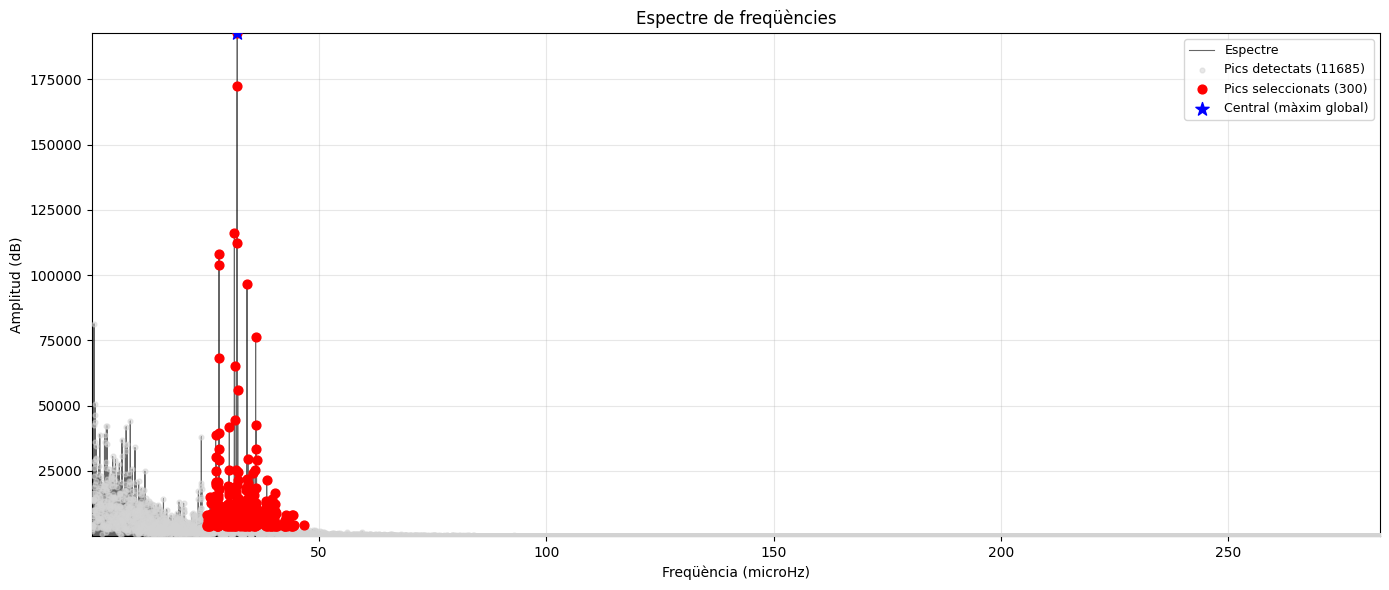

In [5]:
# Visualitzar espectre amb pics seleccionats
plot_spectrum(freqs, amps, initial_peaks, selected_peaks, global_max_idx, 
              freq_unit=FREQ_UNIT)

## 3. Anàlisi de diferències, histograma i autocorrelació

In [6]:
# Calcular diferències entre parells de pics
pairwise_diffs = compute_pairwise_differences(freqs, selected_peaks)
deltas = np.array([d[1] for d in pairwise_diffs])

print(f"Diferència mínima: {deltas.min():.6f} {FREQ_UNIT}")
print(f"Diferència màxima: {deltas.max():.6f} {FREQ_UNIT}")
print(f"Diferència mitjana: {deltas.mean():.6f} {FREQ_UNIT}")

Diferència mínima: 0.015755 microHz
Diferència màxima: 21.513639 microHz
Diferència mitjana: 5.610971 microHz



Pic màxim d'autocorrelació (Δν): 4.041 microHz


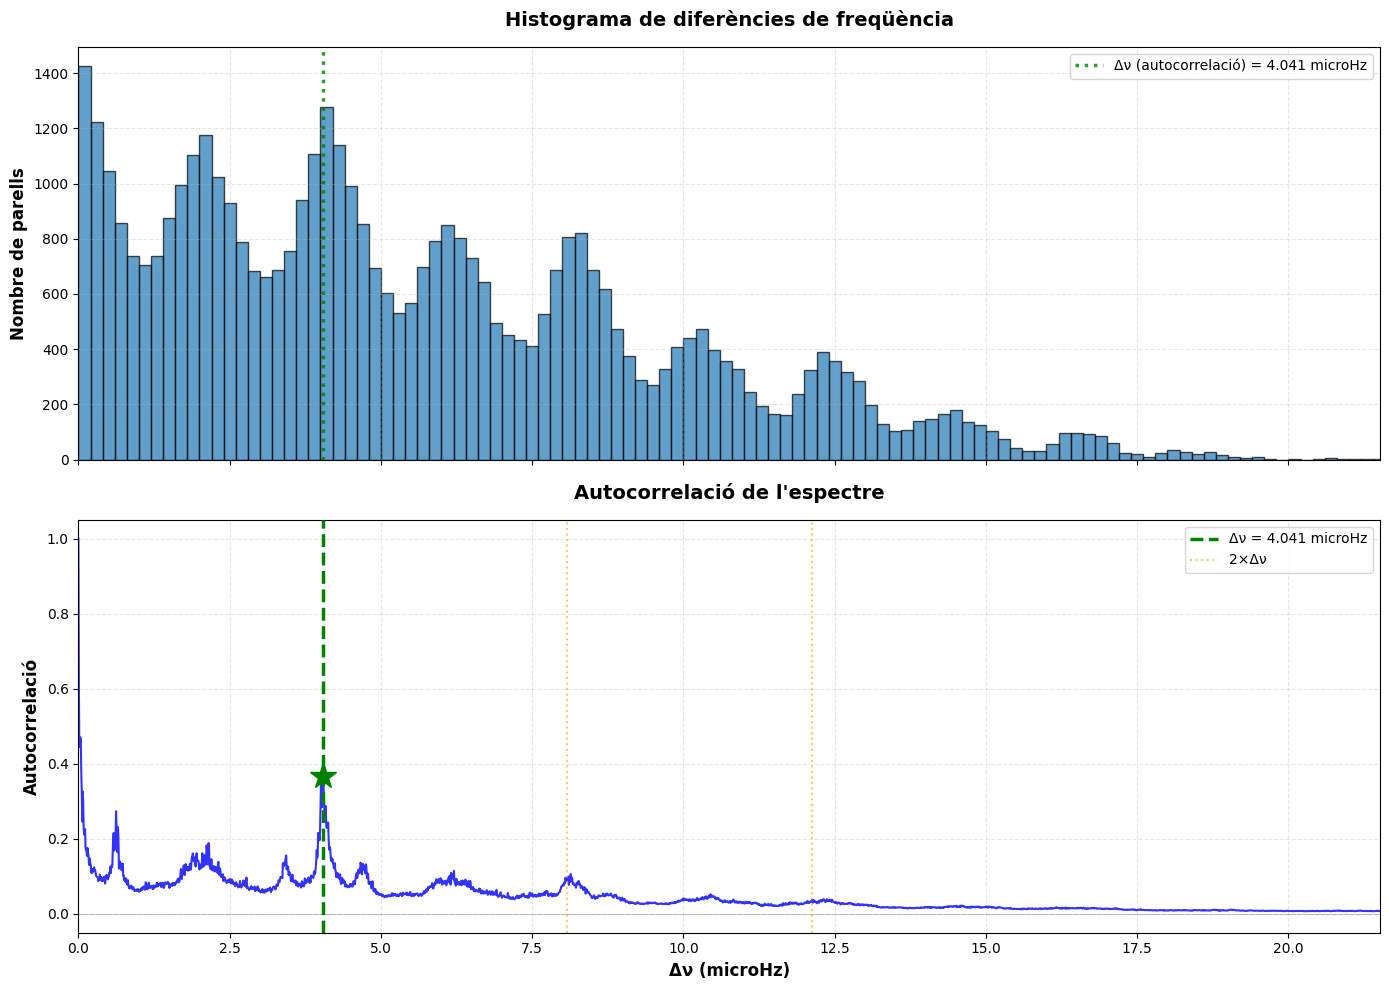


Bins amb més parells (excloent zona < 1.076 microHz):
  4.100 microHz: 1279 parells
  2.100 microHz: 1177 parells
  4.300 microHz: 1141 parells
  3.900 microHz: 1106 parells
  1.900 microHz: 1103 parells


In [7]:
# Histograma i autocorrelació
if CALCULAR_AUTOCORRELACIO:
    # Calcular autocorrelació
    lags, autocorr, autocorr_peak = compute_autocorrelation(
        freqs, amps, 
        freq_range_min=FREQ_RANGE_MIN,
        freq_range_max=FREQ_RANGE_MAX,
        exclude_near_zero=0.05
    )
    print(f"\nPic màxim d'autocorrelació (Δν): {autocorr_peak:.3f} {FREQ_UNIT}")
    
    # Visualització combinada histograma + autocorrelació
    plot_histogram_with_autocorrelation(
        deltas, lags, autocorr, autocorr_peak,
        bin_width=BIN_WIDTH, freq_unit=FREQ_UNIT,
        exclude_near_zero=EXCLUDE_NEAR_ZERO
    )
else:
    # Només histograma (Sol)
    plot_histogram_with_autocorrelation(
        deltas, bin_width=BIN_WIDTH, freq_unit=FREQ_UNIT,
        exclude_near_zero=EXCLUDE_NEAR_ZERO
    )

## 4. Exportació de resultats

In [8]:
# Guardar resultats en fitxers CSV
bins = np.arange(0.0, deltas.max() + BIN_WIDTH, BIN_WIDTH)
counts, edges = np.histogram(deltas, bins=bins)

save_results(freqs, amps, selected_peaks, global_max_idx, 
             pairwise_diffs, counts, edges, OUTPUT_DIR, BIN_WIDTH, FREQ_UNIT)

Pics seleccionats guardats a: output/estrellaD\peaks_around_central.csv
Diferències entre parells guardades a: output/estrellaD\pairwise_differences.csv
Histograma guardat a: output/estrellaD\histogram_0.20microHz.csv
